In [1]:

from glob import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal as signal
from scipy.interpolate import interp1d
import os


def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): The type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt



def climatology1d(data, times, period=365, nharmonics=3):
    """
    This function computes the annual cycle of a time series 
    taking advantage of the fourier series decomposition and 
    that seasonal changes are equal to the 365 time scale 
    variability. 
    
    By defaults the function assumes the input data has a 
    daily sampling, if not modify "period" argument properly. 

    Args:
        data (array): (n, ) dimensional array with time-ordered data
        times (array):(n, ) dimensional array of time objects
        period (int, optional): Period to remove. Defaults to 365.
        nharmonics (int, optional): Number of harmonics related to 
        the fundamental frequency to remove. Defaults to 3.

    Returns:
        array: (365, ) dimensional array with the climatological
        value of each day.
        
    Reference: Statistical Methods in the Atmospheric Sciences
              Daniel S. Wilks. Part II Univariate Statistics, 
              Chapter 9.4: Frequency Domain - Harmonic Analysis
              
    Example 9.8: Transforming a Cosine Wave to Represent an Annual Cycle
    Section 9.4.3: Estimation of the Amplitude and Phase of a Single Harmonic
    Section 9.4.4: Higher Harmonics
    Example 9.11: A more Complicated Annual Cycle
    """
    
    # If data has nans return full nan vector
    if np.isnan(data).sum()!=0:
        return np.nan*np.ones(365)
    # Transform data to pandas timeseries
    data   = pd.Series(data, index = pd.to_datetime(times))
    # Remove leap day of leap years and NaNs
    data   = data[~((data.index.month==2)&(data.index.day==29))]
    # Number of timestemps
    n      = len(data) 
    # Compute sample mean
    clim  = np.mean(data)*np.ones(n)
    for k in range(nharmonics):
        # Target frequency
        freq       = 2*np.pi*(k+1)*np.arange(1,n+1)/period
        # Compute harmonic coefficient as a "naive" discrete
        # fourier transform
        Ak        = (2/n)*np.sum(data*np.cos(freq)) 
        Bk        = (2/n)*np.sum(data*np.sin(freq)) 
        # Add up harmonics to the annual cycle
        clim      = clim+Ak*np.cos(freq)+Bk*np.sin(freq)
    clim = pd.Series(clim, index=data.index).to_xarray().rename({'index':'time'})
    clim = clim.to_dataset(name='_').convert_calendar('noleap')['_']
    clim = clim.groupby("time.dayofyear").mean()
    return clim.to_series()

def climatology_xarray(data, dim, period=365, nharmonics=3, parallel=False, **kwargs):
    """
    Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function climatology1d along the time dimension return the spatial
    climatology.

    Args:
        data (_type_): _description_
        dim (_type_): _description_
        period (int, optional): _description_. Defaults to 365.
        nharmonics (int, optional): _description_. Defaults to 3.
        parallel (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    clim = xr.apply_ufunc(climatology1d, data, kwargs={'times':data.time,
                                                       'period':period,
                                                       'nharmonics':nharmonics},
                          input_core_dims=[[dim],],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask,
                          dask_gufunc_kwargs={'allow_rechunk':True},
                          **kwargs)
    clim = clim.rename({'time':'dayofyear'})
    clim.coords['dayofyear'] = np.arange(1, len(clim.dayofyear)+1)
    return clim

def intraseasonal_anomalies(data, method='cubic', **kwargs):
     """
     Given a pandas or xarray object with daily ordered data, this function
     computes the intraseasonal anomaly using the following method:
     1) Resample data to monthly means centered on the middle of the month
     2) Interpolate monthly data back to daily using splines (default)
     3) Compute the anomaly as the original data minus the interpolated one.
     4) Return the anomaly

     Args:
         data (array): daily ordered data
         method (str, optional): type of interpolation. Defaults to 'cubic'.
         **kwargs passed to interpolate function (scipy?)

     Raises:
         ValueError: If the xarray object doesnt have a "time" coordinate
         ValueError: If the input data is not a pandas or xarray object

     Returns:
         anomaly: intraseasonal anomalies
     """
     mask = ~np.isnan(data)
     if 'pandas' in str(type(data)):
          data = data.resample('d').interpolate(method='nearest')
          data.index = data.index.to_datetimeindex()
          lowfreq_variability = data.resample('m').mean()
          lowfreq_variability.index = lowfreq_variability.index-pd.Timedelta(days=14)
          lowfreq_variability = lowfreq_variability.resample('d').interpolate(method=method, **kwargs)
     elif 'xarray' in str(type(data)):
          if 'time' in data.coords:
               data = data.resample({'time':'D'}).interpolate(kind='nearest').fillna(-9999)
               lowfreq_variability = data.resample({'time':'MS'}, loffset=pd.Timedelta(days=14)).mean()
               lowfreq_variability = lowfreq_variability.resample({'time':'D'}).interpolate(kind=method, **kwargs)
          else:
               raise ValueError('xarray object must have a \'time\' dimension!')
     else:
          raise ValueError('Input data must be an xarray or pandas object!')
     data = data.where(mask==1)
     anomaly = data-lowfreq_variability
     return anomaly



In [6]:
glorys12 = xr.open_mfdataset('data/GLORYS12V1/SST/*.nc').squeeze()
glorys12 = glorys12.sel(time=~((glorys12.time.dt.month==2)&(glorys12.time.dt.day==29))).compute()
# glorys12 = glorys12.convert_calendar('noleap')
glorys12_clim = climatology_xarray(glorys12, 'time')
glorys12_clim.to_netcdf('data/GLORYS12V1/SST_CLIMATOLOGY.nc')

In [24]:
glorys12_clim = xr.open_dataset('data/GLORYS12V1/ZOS_CLIMATOLOGY.nc').load()
# glorys12['zos_anomaly'] = glorys12['zos'].groupby('time.dayofyear')-glorys12_clim.zos
# glorys12['zos_anomaly'] = glorys12['zos'].groupby('time.dayofyear') - glorys12_zosclim['zos']
# glorys12['zos_anomaly']




In [ ]:
glorys12 = xr.open_mfdataset('data/GLORYS12V1/ZOS/*.nc')
glorys12 = glorys12.sel(time=~((glorys12.time.dt.month==2)&(glorys12.time.dt.day==29))).compute()
glorys12 = glorys12.convert_calendar('noleap')

for yr in range(1993,2021):
    for m in range(1,13):
        try:
            m  = "%02d" % m
            yr = str(yr)
            print(yr,'-',m)
            x = glorys12['zos_anomaly'].sel(time=yr+'-'+m)
            x = x.drop('dayofyear').convert_calendar('gregorian').to_dataset(name='zos_anomaly')
            x.time.encoding['units'] = 'days since 1900-01-01'
            x.to_netcdf('data/GLORYS12V1/ZOS/ANOMALY/ZOS_ANOMALY_Y'+yr+'M'+m+'.nc')
        except:
            pass

In [2]:
reforecasts = sorted(glob("data/S2S/reforecasts/*[!.nc]"))
DATA = []
for p in reforecasts:
    print(p)
    if not os.path.isfile(p+'/merged_SST.nc'):
        data = []
        for r in glob(p+'/*_SST.nc'):
            dd = xr.open_dataset(r, chunks=dict(time=-1)).squeeze()
            dd = dd.rename({'time':'leadtime'})
            dd['leadtime'] = np.arange(len(dd['leadtime']))
            dd['time'] = pd.to_datetime(r.split("/")[-1].replace(".nc",""))
            data.append(dd)
        data = xr.concat(data,'time')
        # data.to_netcdf(p+'/merged.nc')
    else:
        data = xr.open_dataset(p+'/merged_SST.nc').sortby('lat').sel(lat=slice(-60,15), lon=slice(360-150,360-69))
        data = data.load()
    DATA.append(data)
print('Joining...')
DATA = xr.concat(DATA,'time').sortby('time')
DATA = DATA.sel(time=~((DATA.time.dt.month==2)&(DATA.time.dt.day==29)))
DATA['lon'] = (DATA['lon']%180)-180
DATA = DATA.drop_duplicates('time')#.resample({'time':'d'}).interpolate(kind='nearest')
DATA = DATA.convert_calendar('noleap')
DATA

In [76]:
DATA = xr.open_mfdataset('data/S2S/SST/*.nc').drop('sst_synop')
DATA

,Array,Chunk
Bytes,2.96 GiB,151.11 MiB
Shape,"(46, 6155, 51, 55)","(46, 307, 51, 55)"
Count,66 Tasks,22 Chunks
Type,float32,numpy.ndarray


In [89]:
paths = glob('data/S2S/CLIMATOLOGY/SST*')
leadtimes = [int(p.split('/')[-1].split('LEADTIME')[-1].replace('.nc','')) for p in paths]
sst_clim=[xr.open_dataset(p) for p in paths]
sst_clim=xr.concat(sst_clim, 'leadtime')
sst_clim.coords['leadtime'] = leadtimes
sst_clim = sst_clim.sortby('leadtime')

In [100]:
sst_anomaly = DATA.sst.groupby('time.dayofyear')-sst_clim.rename({'lat':'latitude','lon':'longitude'}).sst

In [118]:
DATA = xr.merge([DATA,sst_anomaly.to_dataset(name='sst_anomaly')])
DATA

In [120]:
for yr in range(2000,2022):
    print(yr)
    x = DATA.sel(time=str(yr))
    # x['sst_synopanom'] = intraseasonal_anomalies(DATA.sst)
    x = x.sortby('longitude').sortby('latitude').sortby('time').sortby('leadtime')
    x = x.transpose('leadtime', 'time', 'latitude', 'longitude')
    x.time.encoding['units'] = "days since 2000-01-06 00:00:00.000000"
    x.to_netcdf('/home/lucas/projects/S2S_FORECAST/data/S2S/SST/backup/'+str(yr)+'.nc', mode='w')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [61]:
s2s_zos_synopanom = intraseasonal_anomalies(DATA.dslm)

/home/lucas/miniconda3/envs/forecast/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/lucas/miniconda3/envs/forecast/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array

In [71]:
DATA = xr.merge([DATA,s2s_zos_synopanom.to_dataset(name='zos_synopanom')])
DATA

<xarray.Dataset>
Dimensions:        (time: 5976, leadtime: 46, latitude: 76, longitude: 82)
Coordinates:
  * time           (time) object 2000-01-06 00:00:00 ... 2021-12-08 00:00:00
  * leadtime       (leadtime) int64 0 1 2 3 4 5 6 7 ... 38 39 40 41 42 43 44 45
  * longitude      (longitude) float32 -150.0 -149.0 -148.0 ... -70.0 -69.0
  * latitude       (latitude) float32 -60.0 -59.0 -58.0 -57.0 ... 13.0 14.0 15.0
    depth          float64 0.0
    dayofyear      (time) float64 dask.array<chunksize=(104,), meta=np.ndarray>
Data variables:
    dslm           (leadtime, time, latitude, longitude) float32 dask.array<chunksize=(46, 104, 76, 82), meta=np.ndarray>
    zos_anom       (leadtime, time, latitude, longitude) float32 dask.array<chunksize=(46, 104, 76, 82), meta=np.ndarray>
    zos_synopanom  (leadtime, time, latitude, longitude) float32 dask.array<chunksize=(46, 104, 76, 82), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Fri Dec 09 17:58:34 2022: cdo -f nc copy 2012-01-06.grb ref...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [72]:
for yr in range(2000,2022):
    print(yr)
    x = DATA.sel(time=str(yr))
    # x['sst_synopanom'] = intraseasonal_anomalies(DATA.sst)
    x = x.sortby('longitude').sortby('latitude').sortby('time').sortby('leadtime')
    x = x.transpose('leadtime', 'time', 'latitude', 'longitude')
    x.time.encoding['units'] = "days since 2000-01-06 00:00:00.000000"
    x.to_netcdf('/home/lucas/projects/S2S_FORECAST/data/S2S/SSH/'+str(yr)+'.nc', mode='a')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [ ]:
print('computing climatology')
for i,lead in enumerate(DATA.leadtime):
        clim = climatology_xarray(DATA.sel(leadtime=lead).dslm, 'time')
        #anom = DATA.sel(leadtime=lead).dslm.convert_calendar('noleap').groupby('time.dayofyear')-clim
        print('saving to netcdf: LEADTIME '+str(i))
#for i,lead in enumerate(clim.leadtime):
        clim.to_dataset(name='dslm').to_netcdf('data/S2S/CLIMATOLOGY/SSH_LEADTIME'+str(i)+'.nc',
                                               encoding={'dslm':{'dtype':'float32'},
                                                         'depth':{'dtype':'float32'}})

In [13]:
paths = sorted(glob('data/S2S/CLIMATOLOGY/*'))
leadtimes = [p.split(".nc")[0][-3:].replace('M','').replace('E','') for p in paths]
clim = [xr.open_dataset(p) for p in paths]
clim = xr.concat(clim, 'leadtime')
clim.coords['leadtime'] = ('leadtime',np.array(leadtimes).astype(int))
clim = clim.sortby('leadtime').sortby('dayofyear').transpose('leadtime','dayofyear','lat','lon')
clim

<xarray.Dataset>
Dimensions:    (leadtime: 46, lon: 82, lat: 76, dayofyear: 365)
Coordinates:
  * leadtime   (leadtime) int64 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44 45
  * lon        (lon) float32 -150.0 -149.0 -148.0 -147.0 ... -71.0 -70.0 -69.0
  * lat        (lat) float32 -60.0 -59.0 -58.0 -57.0 ... 12.0 13.0 14.0 15.0
    depth      float32 0.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    dslm       (leadtime, dayofyear, lat, lon) float32 -1.606 -1.625 ... 0.1886

In [146]:
for yr in range(2000,2022):
    print(yr)
    x = DATA.sel(time=str(yr))
    # x['sst_synopanom'] = intraseasonal_anomalies(DATA.sst)
    x = x.rename({'lat':'latitude','lon':'longitude'}).sortby('longitude').sortby('latitude').sortby('time').sortby('leadtime')
    x = x.transpose('leadtime', 'time', 'latitude', 'longitude')
    x.time.encoding['units'] = "days since 2000-01-06 00:00:00.000000"
    x.to_netcdf('data/S2S/reforecasts/'+str(yr)+'.nc')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [76]:
for yr in range(2000,2022):
    print(yr)
    x = DATA.sel(time=str(yr))
    x['zos_anom'] = (x['dslm'].groupby('time.dayofyear')-clim.dslm)
    x = x.rename({'lat':'latitude','lon':'longitude'}).sortby('longitude').sortby('latitude').sortby('time').sortby('leadtime')
    x = x.transpose('leadtime', 'time', 'latitude', 'longitude')
    x.to_netcdf('data/S2S/reforecasts/'+str(yr)+'.nc')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [16]:
glorys12_sst = xr.open_mfdataset('~/storage/GLORYS12V1/SST/*.nc').load()
glorys12_sst = glorys12_sst.rename({'thetao':'sst'}).squeeze()

In [19]:
glorys12_sstsynop = intraseasonal_anomalies(glorys12_sst.sst.reindex({'time':glorys12_sst.time-pd.Timedelta(hours=12)}, method='nearest')).reindex({'time':glorys12_sst.time}, method='nearest').squeeze()

In [25]:
glorys12 = xr.merge([glorys12_sst,glorys12_sstsynop.to_dataset(name='sst_synopanom')])
glorys12 = glorys12.transpose('time','latitude','longitude')

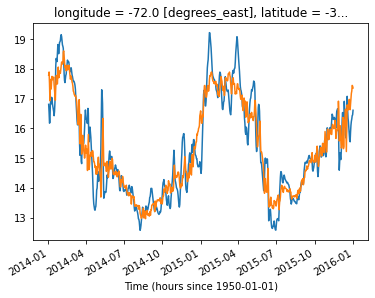

In [50]:
(glorys12.sst.sel(latitude=-30, longitude=-72, method='nearest')).sel(time=slice('2014','2015')).plot()
(glorys12.sst.sel(latitude=-30, longitude=-72, method='nearest')-glorys12.sst_synopanom.sel(latitude=-30, longitude=-72, method='nearest')).sel(time=slice('2014','2015')).plot()


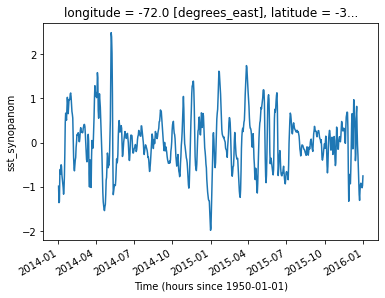

In [51]:
(glorys12.sst_synopanom.sel(latitude=-30, longitude=-72, method='nearest')).sel(time=slice('2014','2015')).plot()

In [52]:
glorys12

<xarray.Dataset>
Dimensions:        (time: 9951, longitude: 121, latitude: 301)
Coordinates:
  * time           (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-05-31T1...
  * longitude      (longitude) float32 -80.0 -79.92 -79.83 ... -70.08 -70.0
  * latitude       (latitude) float32 -40.0 -39.92 -39.83 ... -15.08 -15.0
    depth          float32 0.494
Data variables:
    sst            (time, latitude, longitude) float32 14.84 14.74 ... nan nan
    sst_synopanom  (time, latitude, longitude) float64 0.2387 0.1846 ... nan nan
Attributes: (12/25)
    CDI:                                Climate Data Interface version ?? (ht...
    Conventions:                        CF-1.4
    history:                            Thu Aug 18 11:34:52 2022: cdo mergeti...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    title:                              daily mean fields from Global Ocean P...
    ...                                 ...
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention
    CDO:                                Climate Data Operators version 1.9.3 ...

In [55]:
for yr in range(1993,2021):
    print(yr)
    yr = str(yr)
    # glorys12_zosanom  = xr.open_mfdataset('~/storage/GLORYS12V1/ZOS/backup/ANOMALY/*'+yr+'*.nc').load()
    # x = xr.merge([glorys12.sel(time=yr), glorys12_zosanom])
    x = glorys12.sel(time=yr)
    x.to_netcdf('~/storage/GLORYS12V1/SST/GLORYS12V1_SST_Y'+yr+'.nc', encoding={'sst':{'zlib':True, 'dtype':'float32'},
                                                    'sst_synopanom':{'zlib':True, 'dtype':'float32'}})

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
